# Raport

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

#sns.set_style('darkgrid')

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
#import pmdarima as pm

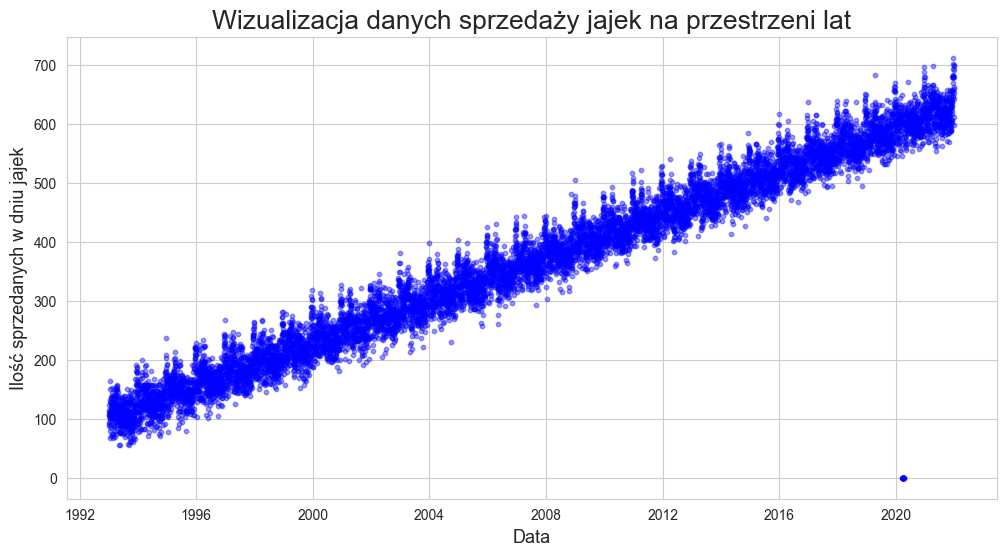

In [23]:
data=pd.read_csv("train_egg_sales.csv",delimiter=';')
data['Date'] = pd.to_datetime(data['Date'])

# Wykres scatter
plt.figure(figsize=(12, 6))
plt.scatter(data['Date'], data['Egg Sales'], color='blue', alpha=0.4, s=10)
plt.title('Wizualizacja danych sprzedaży jajek na przestrzeni lat', fontsize=19)
plt.xlabel('Data', fontsize=13)
plt.ylabel('Ilość sprzedanych w dniu jajek', fontsize=13)
plt.show()

In [24]:
data.head()
print(len(data['Egg Sales']))
print(data['Date'][0])
print(data['Date'][10591])

10592
1993-01-01 00:00:00
2021-12-31 00:00:00


## 2.1

## N/A

In [25]:
print(data.isnull().sum()) #N/A
# Liczba brakujących danych w kolumnach
missing_data = data.isnull().sum()
print(f'Brakujące dane:\n{missing_data}')

# Możemy także sprawdzić brakujące dane w kontekście wartości sprzedaży jajek
missing_sales = data[data['Egg Sales'].isnull()]
print(f'Brakujące dane w sprzedaży jajek:\n{missing_sales}')


Date         0
Egg Sales    0
dtype: int64
Brakujące dane:
Date         0
Egg Sales    0
dtype: int64
Brakujące dane w sprzedaży jajek:
Empty DataFrame
Columns: [Date, Egg Sales]
Index: []


## detekcja wartości spoza zakładanego przedziału

In [26]:
min(data['Egg Sales'])

0

In [27]:
data.nsmallest(40, 'Egg Sales')

,Date,Egg Sales
9941,2020-03-21,0
9942,2020-03-22,0
9943,2020-03-23,0
9944,2020-03-24,0
9945,2020-03-25,0
9946,2020-03-26,0
9947,2020-03-27,0
9948,2020-03-28,0
9949,2020-03-29,0
9950,2020-03-30,0


In [28]:
max(data['Egg Sales'])

713

Liczba próbek spoza zakładanego przedziału: 18


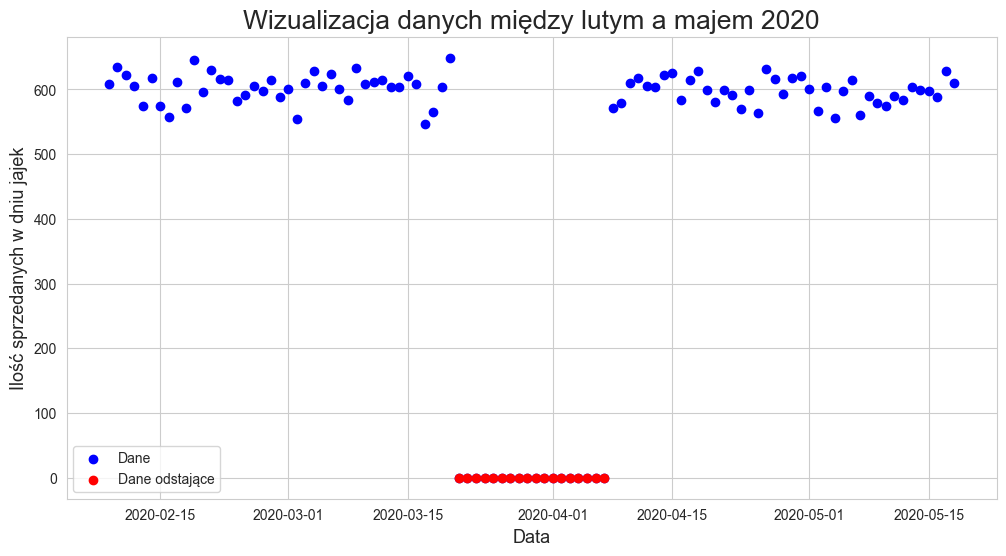

In [29]:
min_value=55
max_value=713
out_of_range_data = data[(data['Egg Sales'] < min_value) | (data['Egg Sales'] > max_value)]
print(f'Liczba próbek spoza zakładanego przedziału: {len(out_of_range_data)}')

plt.figure(figsize=(12, 6))
plt.scatter(data['Date'][9900:10000], data['Egg Sales'][9900:10000], color='blue', label='Dane')
plt.scatter(data['Date'][9941:9959], data['Egg Sales'][9941:9959], color='red', label='Dane odstające')
#plt.plot(data['Egg Sales'][9941:9959], 'ro')
plt.title('Wizualizacja danych między lutym a majem 2020', fontsize=19)
plt.xlabel('Data', fontsize=13)
plt.ylabel('Ilość sprzedanych w dniu jajek', fontsize=13)
plt.legend()
plt.show()

## Błedy w próbkowaniu

In [30]:
# Sprawdzenie różnic między kolejnymi datami
data['Time Diff'] = data['Date'].diff()

# Jeśli różnice czasowe są zbyt duże (np. > 1 dzień), może to wskazywać na brakujące próbki
irregular_dates = data[data['Time Diff'] > pd.Timedelta(days=1)]
print(f'Nieregularne daty (z dużą różnicą czasową):{irregular_dates}')


Nieregularne daty (z dużą różnicą czasową):Empty DataFrame
Columns: [Date, Egg Sales, Time Diff]
Index: []


In [31]:
# Analiza wartości odstających (outliers) za pomocą IQR (Interquartile Range)
Q1 = data['Egg Sales'].quantile(0.25)
Q3 = data['Egg Sales'].quantile(0.75)
IQR = Q3 - Q1

# Zdefiniowanie przedziału wartości normalnych
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identyfikacja wartości odstających
outliers = data[(data['Egg Sales'] < lower_bound) | (data['Egg Sales'] > upper_bound)]
print(f'Wartości odstające (outliers):\n{outliers}')


Wartości odstające (outliers):
Empty DataFrame
Columns: [Date, Egg Sales, Time Diff]
Index: []


## 2.2

In [32]:
test = pd.read_csv("test_egg_sales.csv",delimiter=';')
print(test.head())
print("Długość próbki", len(test['Date']))
print(test['Date'][0])
print(test['Date'][len(test['Date'])-1])

         Date
0  2022-01-01
1  2022-01-02
2  2022-01-03
3  2022-01-04
4  2022-01-05
Długość próbki 358
2022-01-01
2022-12-24


## 2.3

### wykres ACF oraz PACF dla surowych danych

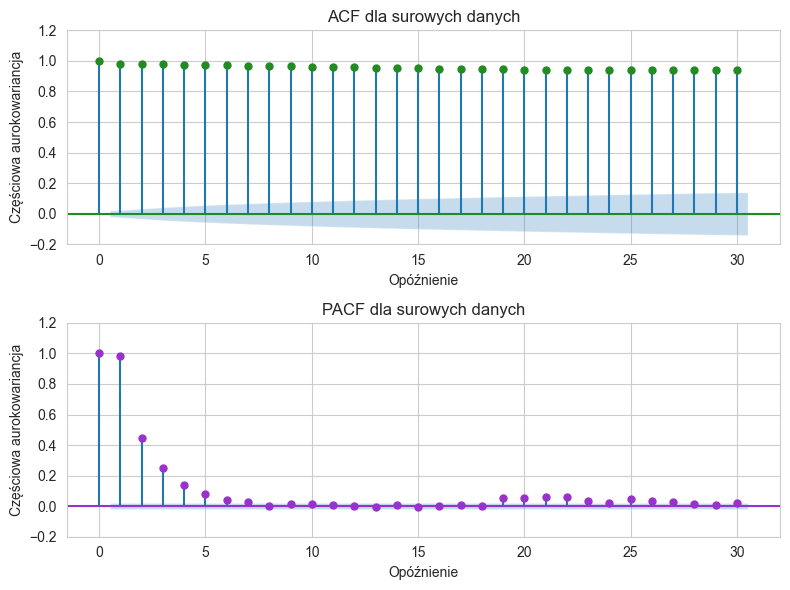

In [33]:
plt.figure(figsize=(8, 6))

# Wykres ACF (Autocorrelation Function)
plt.subplot(2, 1, 1)
plot_acf(data['Egg Sales'], lags=30, ax=plt.gca(), alpha=0.05, color='forestgreen') 
plt.title("ACF dla surowych danych")
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa aurokowariancja')
plt.ylim((-0.2,1.2))

# Wykres PACF (Partial Autocorrelation Function)
plt.subplot(2, 1, 2)
plot_pacf(data['Egg Sales'], lags=30, ax=plt.gca(), alpha=0.05, color='darkorchid')
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa aurokowariancja')
plt.title("PACF dla surowych danych")
plt.ylim((-0.2,1.2))

plt.tight_layout()
#(Boxa-Coxa),
plt.show()

### identyfikacja trendów deterministycznych: metody omawiane na wykładzie oraz na laboratorium -
(zadanie 4, lista 5) / różnicowanie / różnicowanie sezonowe / transformacje stabilizujące wariancję
(Boxa-Coxa),

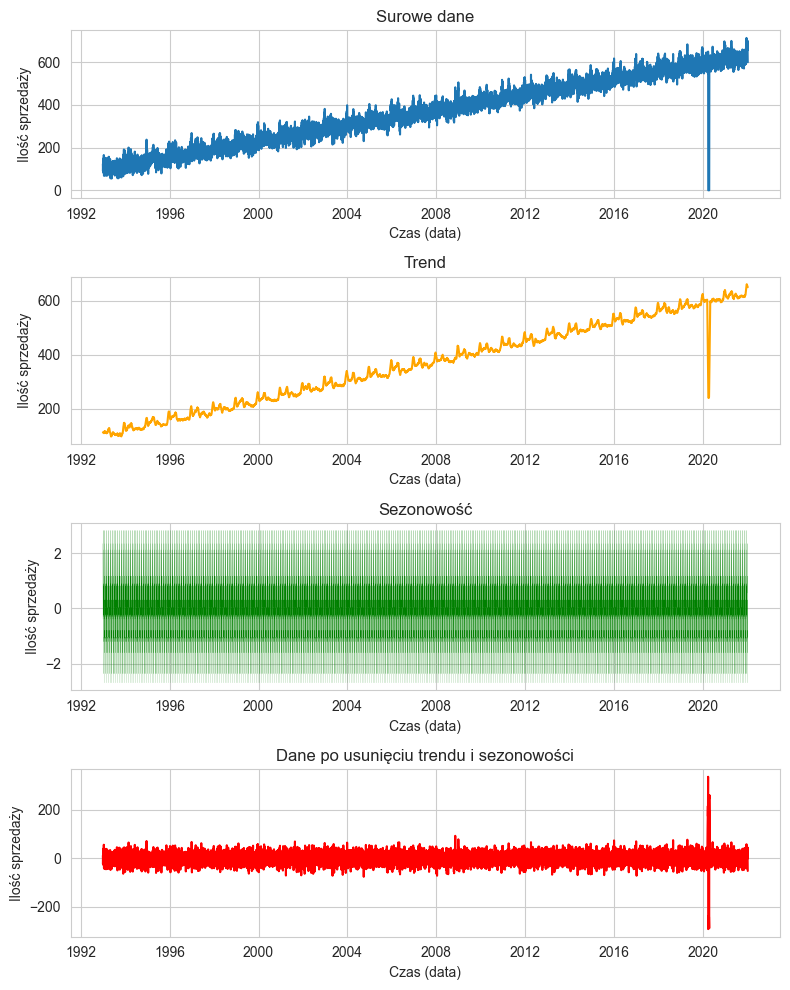

In [34]:
arma_trajectory_with_components = data['Egg Sales']
time = data['Date']
decomposition = seasonal_decompose(arma_trajectory_with_components, model='additive', period=30, extrapolate_trend=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(8,10))

plt.subplot(4, 1, 1)
plt.plot(time, arma_trajectory_with_components, label='Original')
plt.ylabel('Ilość sprzedaży')
plt.xlabel('Czas (data)')
plt.title('Surowe dane')

plt.subplot(4, 1, 2)
plt.plot(time, trend, label='Trend', color='orange')
plt.ylabel('Ilość sprzedaży')
plt.xlabel('Czas (data)')
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(time, seasonal, label='Seasonal', color='green', lw=0.1)
plt.ylabel('Ilość sprzedaży')
plt.xlabel('Czas (data)')
plt.title('Sezonowość')

plt.subplot(4, 1, 4)
plt.plot(time, residual, label='Residual', color='red')
plt.ylabel('Ilość sprzedaży')
plt.xlabel('Czas (data)')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

### ACF i PACF dla uzyskanego szeregu

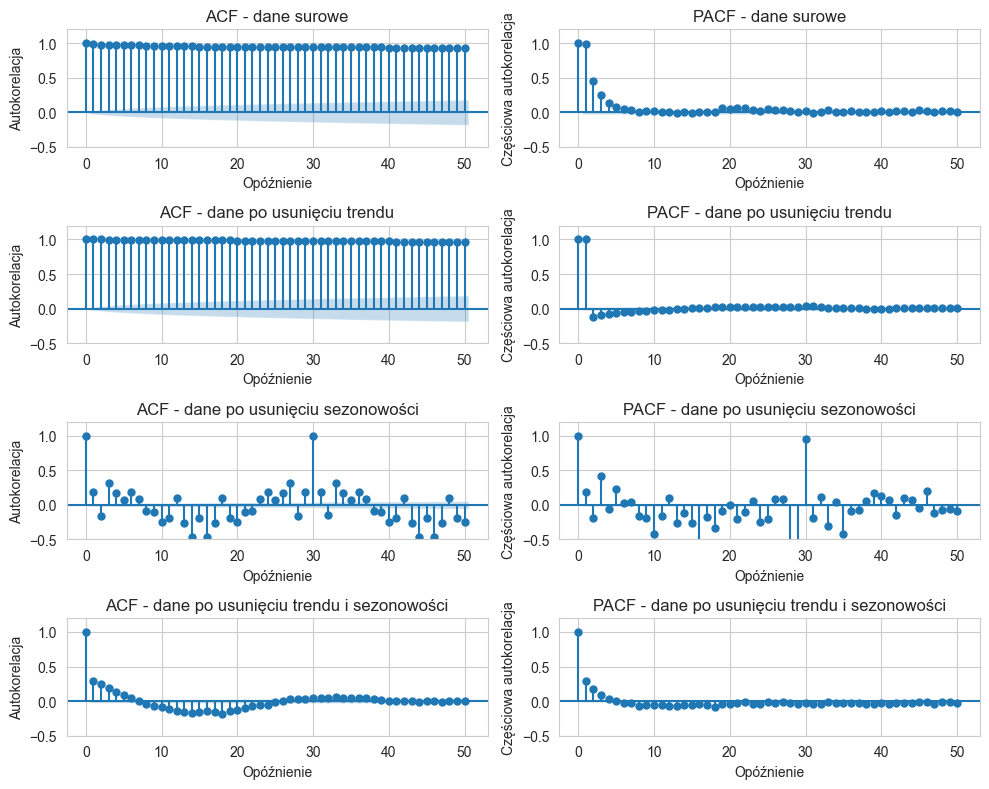

In [35]:
fig, axes = plt.subplots(4, 2, figsize=(10,8))

plot_acf(arma_trajectory_with_components, lags=50, ax=axes[0, 0])
axes[0, 0].set_xlabel('Opóźnienie')
axes[0, 0].set_ylabel('Autokorelacja')
axes[0, 0].set_title('ACF - dane surowe')
axes[0, 0].set_ylim(-0.5, 1.2)

plot_pacf(arma_trajectory_with_components, lags=50, ax=axes[0, 1])
axes[0, 1].set_xlabel('Opóźnienie')
axes[0, 1].set_ylabel('Częściowa autokorelacja')
axes[0, 1].set_title('PACF - dane surowe')
axes[0, 1].set_ylim(-0.5, 1.2)

plot_acf(trend, lags=50, ax=axes[1, 0])
axes[1, 0].set_xlabel('Opóźnienie')
axes[1, 0].set_ylabel('Autokorelacja')
axes[1, 0].set_title('ACF - dane po usunięciu trendu')
axes[1, 0].set_ylim(-0.5, 1.2)

plot_pacf(trend, lags=50, ax=axes[1, 1])
axes[1, 1].set_xlabel('Opóźnienie')
axes[1, 1].set_ylabel('Częściowa autokorelacja')
axes[1, 1].set_title('PACF - dane po usunięciu trendu')
axes[1, 1].set_ylim(-0.5, 1.2)

plot_acf(seasonal, lags=50, ax=axes[2, 0])
axes[2, 0].set_xlabel('Opóźnienie')
axes[2, 0].set_ylabel('Autokorelacja')
axes[2, 0].set_title('ACF - dane po usunięciu sezonowości')
axes[2, 0].set_ylim(-0.5, 1.2)

plot_pacf(seasonal, lags=50, ax=axes[2, 1])
axes[2, 1].set_xlabel('Opóźnienie')
axes[2, 1].set_ylabel('Częściowa autokorelacja')
axes[2, 1].set_title('PACF - dane po usunięciu sezonowości')
axes[2, 1].set_ylim(-0.5, 1.2)

plot_acf(residual, lags=50, ax=axes[3, 0])
#axes[2, 0].plot(acf_teor_, '-', label='Teoretyczna ACF')
axes[3, 0].set_xlabel('Opóźnienie')
axes[3, 0].set_ylabel('Autokorelacja')
axes[3, 0].set_title('ACF - dane po usunięciu trendu i sezonowości')
axes[3, 0].set_ylim(-0.5, 1.2)

plot_pacf(residual, lags=50, ax=axes[3, 1])
#axes[2, 1].plot(pacf_teor_, '-', label='Teoretyczna PACF')
axes[3, 1].set_xlabel('Opóźnienie')
axes[3, 1].set_ylabel('Częściowa autokorelacja')
axes[3, 1].set_title('PACF - dane po usunięciu trendu i sezonowości')
axes[3, 1].set_ylim(-0.5, 1.2)

plt.tight_layout()
plt.show()

### Test ADF weryfikujący hipotezę o niestacjonarności (Augmented Dickey-Fuller Test),

In [36]:
def adfuller_test(series, sig=0.05):
    res = adfuller(series, autolag='AIC')
    p_value = round(res[1], 3)
    stats = round(res[0], 3)

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stacjonarny. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Niestacjonarny.")

In [37]:
print("Dla początkowego szeregu:")
adfuller_test(data['Egg Sales'])
print("\nDla oczyszczonego szeregu:")
adfuller_test(residual)

Dla początkowego szeregu:
Statystyka testowa = -1.609, p-value = 0.479 => Niestacjonarny.

Dla oczyszczonego szeregu:
Statystyka testowa = -27.99, p-Value = 0.0 => Stacjonarny. 


# 3.0 Modelowanie danych przy pomocy ARMA
### 3.1 dobranie rzędu modelu (kryteria informacyjne)

In [38]:
'''# Za pomocą kryteriow informacyjnych szukamy rzędu modelu, rozważamy ARMA(p,q), gdzie p, q = {0, 1, 2, 3}
# Współczynniki wielomianu AR i MA

p1 = 0.4
p2 = -0.5
q1 = 0.6
q2 = 0.3

ar_coef = np.array([1, -p1, -p2])
ma_coef = np.array([1, q1, q2])
# Tworzymy obiekt arma process

arma_process = ArmaProcess(ar_coef, ma_coef)
arma_process_trajectory = arma_process.generate_sample(nsample=traj_size, scale=sigma)'''


df = pd.DataFrame()

ps = []
qs = []
BIC = []
AIC = []
HQIC = []

# Maksymalne wartości p i q
max_p = 4
max_q = 4

# Iteracja po możliwych wartościach p i q
for p in range(0, max_p):
    for q in range(0, max_q):
        
        # Dopasowanie modelu ARMA dla danego p i q
        model = ARIMA(arma_trajectory_with_components, order=(p, 0, q))
        model_fit = model.fit()
        
        # Zapisanie wartości p, q oraz wyników kryteriów informacyjnych
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC


In [39]:
df.sort_values(by='AIC').head()

,p,q,AIC,BIC,HQIC
5,1,1,98534.394489,98563.465906,98544.206904
6,1,2,98534.968911,98571.308183,98547.234430
9,2,1,98534.980570,98571.319841,98547.246089
13,3,1,98536.897616,98580.504742,98551.616239
7,1,3,98536.998279,98580.605404,98551.716901


Dla AIC najmniejsza wartość to 98534.394489, która odpowiada modelowi p = 1, q = 1.
Zatem na podstawie AIC najlepszy rząd modelu to p = 1, q = 1.

In [40]:
df.sort_values(by='BIC').head(1)

,p,q,AIC,BIC,HQIC
5,1,1,98534.394489,98563.465906,98544.206904


Na podstawie BIC najlepszy rząd modelu to p=1, q=1.

In [41]:
df.sort_values(by='HQIC').head(1)

,p,q,AIC,BIC,HQIC
5,1,1,98534.394489,98563.465906,98544.206904


Na podstawie HQIC najlepszy rząd modelu to p=1, q=1.
Można też użyć do estymacji pakietu pmdarima

### 3.2 Estymacja parametrów modelu wybraną metodą
Yule Walker?

In [42]:
from statsmodels.tsa.arima.model import ARIMA

# Przygotowanie danych (data['Egg Sales'] to dane wejściowe)
# Możesz dostosować parametry p, d, q w zależności od potrzeb

# Tworzymy model ARIMA
model = ARIMA(data['Egg Sales'], order=(1, 0, 1))  # order=(p,d,q), tutaj przykład p=1, d=0, q=1

# Dopasowanie modelu
fitted_model = model.fit(start_params=None, transformed=True, includes_fixed=False, method='mle')

# Wyświetlenie podsumowania wyników dopasowanego modelu
print(fitted_model.summary())



ValueError: "mle" is not a valid estimator.

# 4. Ocena dopasowania modelu

## 4.1 przedziały ufnosci 

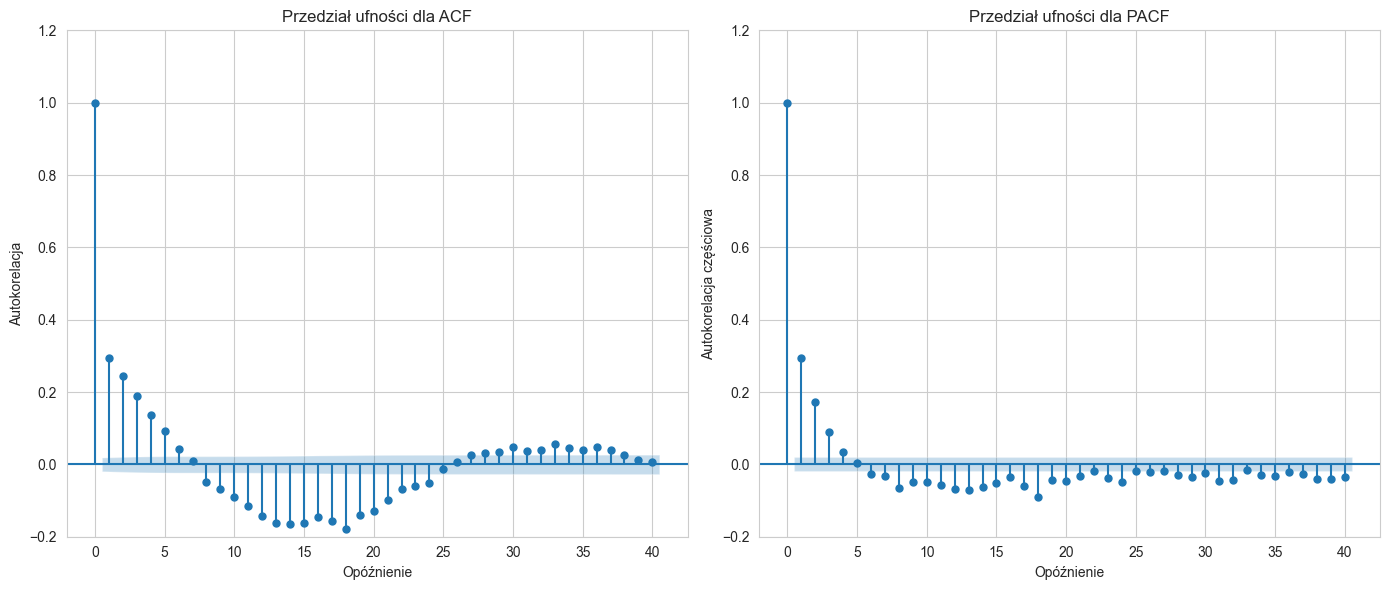

In [50]:

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Wykres ACF
plot_acf(residual, lags=40, alpha=0.05, ax=axes[0])
axes[0].set_title('Przedział ufności dla ACF')
axes[0].set_xlabel('Opóźnienie')  # Tytuł osi X
axes[0].set_ylabel('Autokorelacja')  # Tytuł osi Y
axes[0].set_ylim(-0.2,1.2)
# Wykres PACF
plot_pacf(residual, lags=40, alpha=0.05, ax=axes[1])
axes[1].set_title('Przedział ufności dla PACF')
axes[1].set_xlabel('Opóźnienie')  # Tytuł osi X
axes[1].set_ylabel('Autokorelacja częściowa')  # Tytuł osi Y
axes[1].set_ylim(-0.2,1.2)
# Dostosowanie układu
plt.tight_layout()

# Wyświetlenie wykresu
plt.show()



## 4.2 porównanie linii kwantylowych z trajektorią,

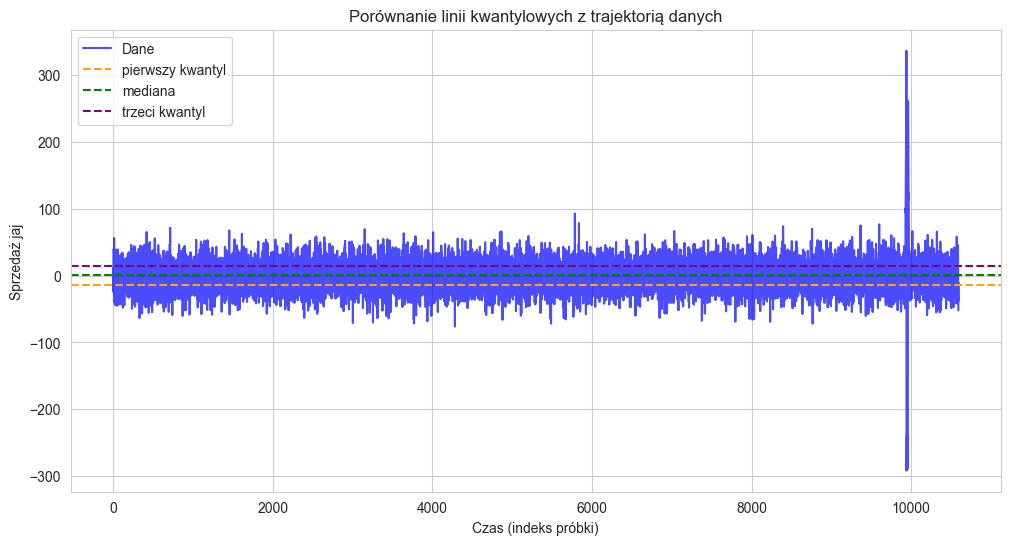

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Zakładamy, że masz już dane w zmiennej `data`
# data = pd.read_csv('twoje_dane.csv')  # Wczytaj swoje dane, jeśli nie są jeszcze załadowane

# Obliczenie kwantyli dla danych treningowych
quantiles = np.quantile(residual, [0.1, 0.25, 0.5, 0.75, 0.9])

# Generowanie trajektorii (np. przewidywania modelu)
# Tutaj zakładamy, że model przewiduje stałą wartość (np. średnią)
model_predictions = np.full_like(residual, np.mean(residual))

# Wizualizacja
plt.figure(figsize=(12, 6))

# Rysowanie trajektorii danych treningowych (w czasie)
plt.plot(residual.values, label='Dane', color='blue', alpha=0.7)


plt.axhline(y=quantiles[1], color='orange', linestyle='--', label='pierwszy kwantyl')
plt.axhline(y=quantiles[2], color='g', linestyle='--', label='mediana')
plt.axhline(y=quantiles[3], color='purple', linestyle='--', label='trzeci kwantyl')




# Dodanie etykiet i legendy
plt.xlabel('Czas (indeks próbki)')
plt.ylabel('Sprzedaż jaj')
plt.title('Porównanie linii kwantylowych z trajektorią danych')
plt.legend()
plt.grid(True)
plt.show()

# Weryfikacja założeń dotyczących szumu
## założenie dot. średniej (wykres wartości resztowych / t test), ?

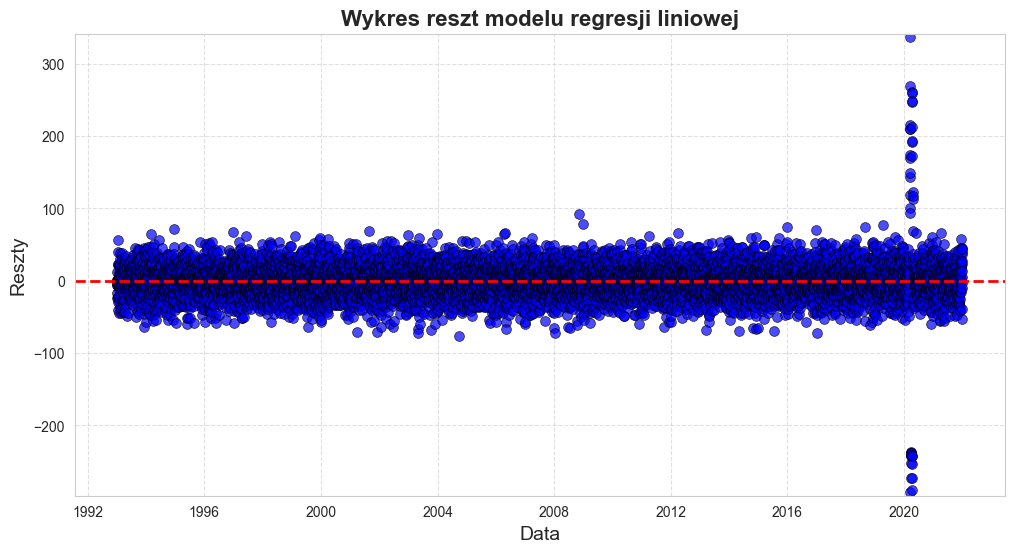

T-statystyka: 0.0000, p-value: 1.0000
Średnia reszt nie różni się istotnie od zera (p > 0.05).


In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
import scipy.stats as stats

X_train = np.arange(len(residual)).reshape(-1, 1)  # Używamy indeksu jako zmiennej niezależnej
y_train = residual

# Budowa modelu regresji liniowej
model = LinearRegression()
model.fit(X_train, y_train)

# Obliczenie reszt
residuals = y_train - model.predict(X_train) 

# Poprawiony wykres reszt
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.scatterplot(x=data['Date'], y=residuals, alpha=0.7, color='blue', edgecolor='black', s=50)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.ylim([min(residuals) - 5, max(residuals) + 5])  # Dopasowanie zakresu osi y
plt.title('Wykres reszt modelu regresji liniowej', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Reszty', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)



plt.show()


# Test t dla średniej reszt
t_stat, p_value = stats.ttest_1samp(residuals, 0)
print(f"T-statystyka: {t_stat:.4f}, p-value: {p_value:.4f}")

if p_value > 0.05:
    print("Średnia reszt nie różni się istotnie od zera (p > 0.05).")
else:
    print("Średnia reszt różni się istotnie od zera (p <= 0.05).")



## założenie dot. wariancji (wykres wartości resztowych / Modified Levene Test / Arch Test),

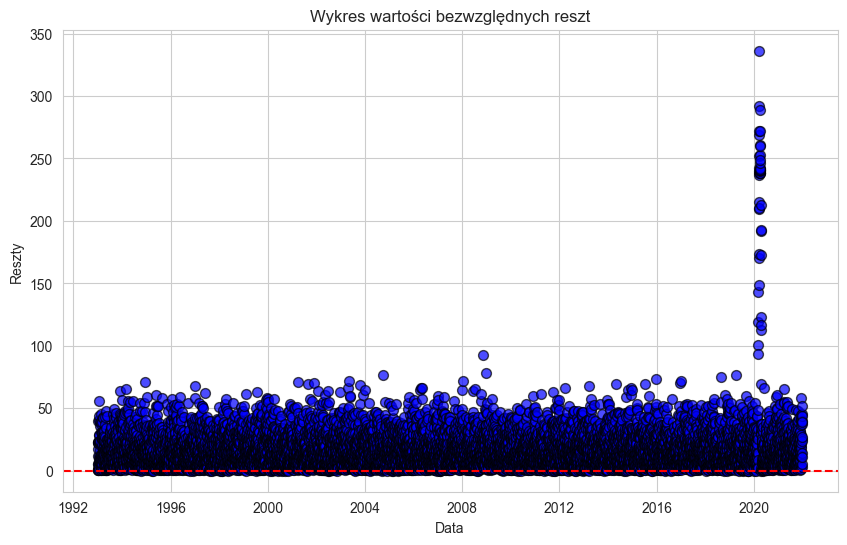

Modified Levene Test: stat=21.448267995042492, p-value=3.678336425673494e-06
Istnieje heteroskedastyczność (p <= 0.05).


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import levene
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import acf



# Przygotowanie danych treningowych
X_train = np.arange(len(data)).reshape(-1, 1)  # Używamy indeksu jako zmiennej niezależnej
y_train = residual

# Budowa modelu regresji liniowej
model = LinearRegression()
model.fit(X_train, y_train)

# Obliczenie reszt
residuals = y_train - model.predict(X_train)

# 1. Wykres reszt
plt.figure(figsize=(10, 6))
plt.scatter(data['Date'], y=np.abs(residuals), alpha=0.7, color='blue', edgecolor='black', s=50)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Wykres wartości bezwzględnych reszt')
plt.xlabel('Data')
plt.ylabel('Reszty')
plt.show()

# 2. Modified Levene Test
# Podziel reszty na dwie grupy (np. pierwsza połowa i druga połowa)
group1 = residuals[:len(residuals)//2]
group2 = residuals[len(residuals)//2:]

# Przeprowadź test Levene’a
stat, p_value = levene(group1, group2)
print(f"Modified Levene Test: stat={stat}, p-value={p_value}")
if p_value > 0.05:
    print("Nie ma dowodów na heteroskedastyczność (p > 0.05).")
else:
    print("Istnieje heteroskedastyczność (p <= 0.05).")



In [71]:
# Unpack only the first two returned values from het_arch
arch_test_stat, arch_p_value, *_ = het_arch(residuals)

print(f"ARCH Test: stat={arch_test_stat}, p-value={arch_p_value}")
if arch_p_value > 0.05:
    print("Brak heteroskedastyczności (p > 0.05).")
else:
    print("Istnieje heteroskedastyczność (p <= 0.05).")


ARCH Test: stat=9512.064764203496, p-value=0.0
Istnieje heteroskedastyczność (p <= 0.05).


In [72]:
arch_test_stat, arch_p_value, f_stat, f_p_value = het_arch(residuals)

print(f"ARCH Test: stat={arch_test_stat}, p-value={arch_p_value}")
print(f"F-statistic: {f_stat}, F-statistic p-value: {f_p_value}")


ARCH Test: stat=9512.064764203496, p-value=0.0
F-statistic: 9397.955433025822, F-statistic p-value: 0.0


## założenie dot. niezależności (wykres ACF/PACF dla wartości resztowych / test Ljunga-Boxa),


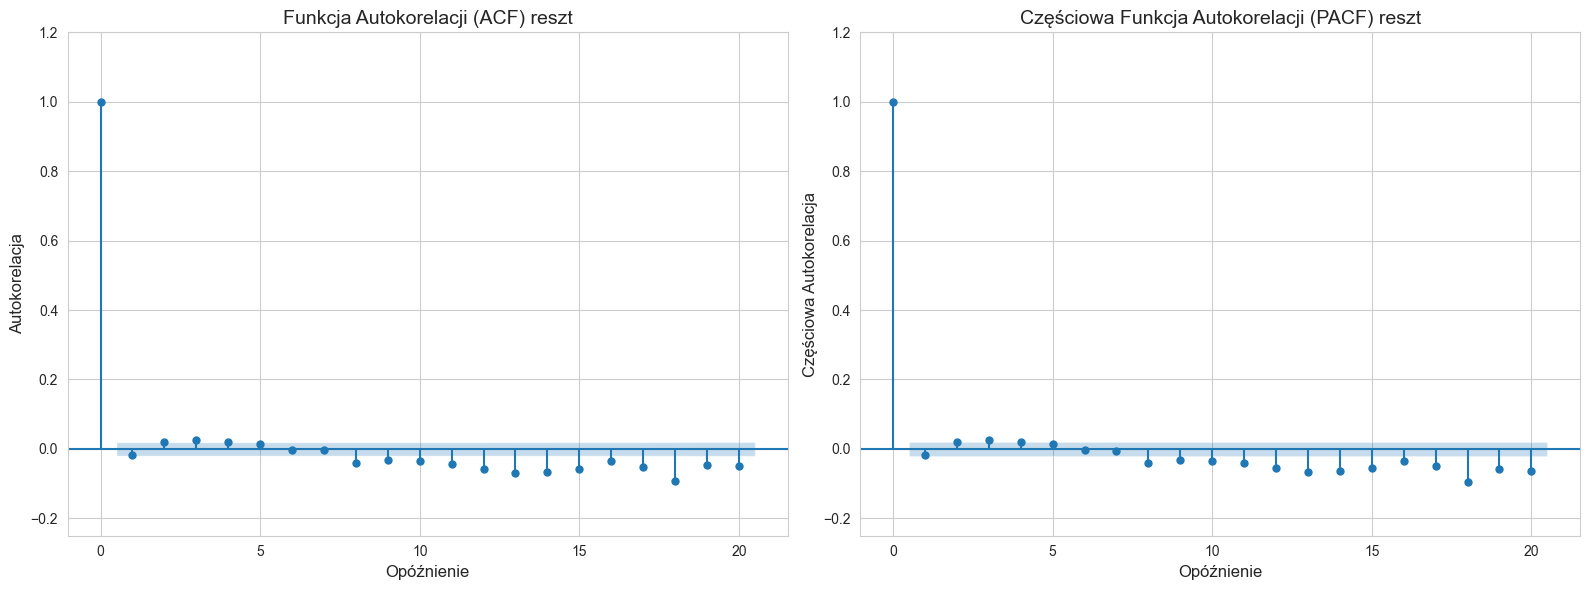

Wynik testu Ljung-Boxa:
      lb_stat     lb_pvalue
10  60.692854  2.679261e-09
Odrzucamy hipotezę zerową - reszty nie są niezależne.


In [79]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

# Assuming 'data' is a dictionary with 'Date' and 'Egg Sales'
df = pd.DataFrame(data)

# Ensure Date column is a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index and enforce frequency
df.set_index('Date', inplace=True)
df = df.asfreq('D')  # Set frequency to daily ('D') or adjust as needed

# Fit an ARIMA model
model = sm.tsa.ARIMA(residual, order=(1, 0, 1))
results = model.fit()
residuals = results.resid  # Residuals from the model

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ACF dla reszt
plot_acf(residuals.dropna(), lags=20, alpha=0.05, ax=axes[0])
axes[0].set_title('Funkcja Autokorelacji (ACF) reszt', fontsize=14)
axes[0].set_xlabel('Opóźnienie', fontsize=12)
axes[0].set_ylabel('Autokorelacja', fontsize=12)
axes[0].set_ylim([-0.25, 1.2])
# PACF dla reszt
plot_pacf(residuals.dropna(), lags=20, alpha=0.05, ax=axes[1])
axes[1].set_title('Częściowa Funkcja Autokorelacji (PACF) reszt', fontsize=14)
axes[1].set_xlabel('Opóźnienie', fontsize=12)
axes[1].set_ylabel('Częściowa Autokorelacja', fontsize=12)
axes[1].set_ylim([-0.25, 1.2])
# Wyświetlenie wykresów
plt.tight_layout()
plt.show()

# Ljung-Box test for residuals
lb_test = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
print("Wynik testu Ljung-Boxa:")
print(lb_test)

# Interpretation of Ljung-Box test results
if lb_test['lb_pvalue'].iloc[0] > 0.05:
    print("Nie ma podstaw do odrzucenia hipotezy zerowej - reszty są niezależne.")
else:
    print("Odrzucamy hipotezę zerową - reszty nie są niezależne.")


## założenie dot. normalności rozkładu (dystrybuanta / gęstość / wykres kwantylowy / testy na normalność).

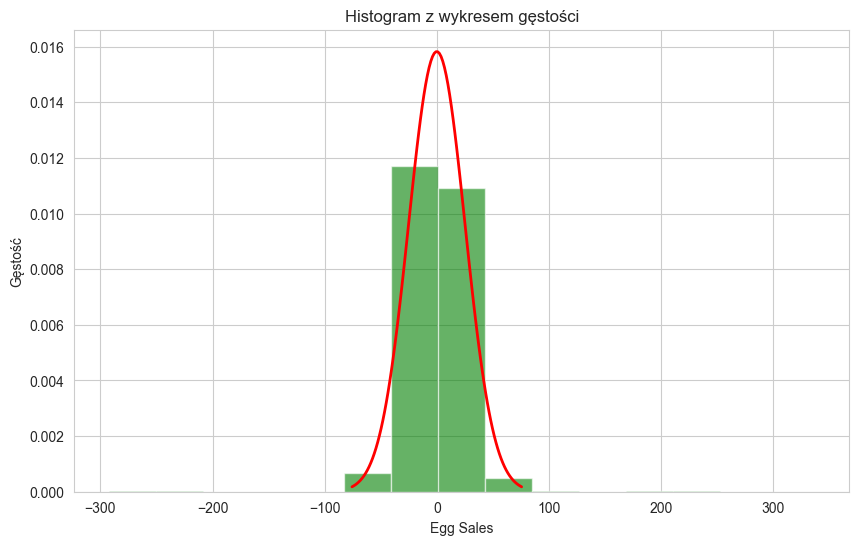

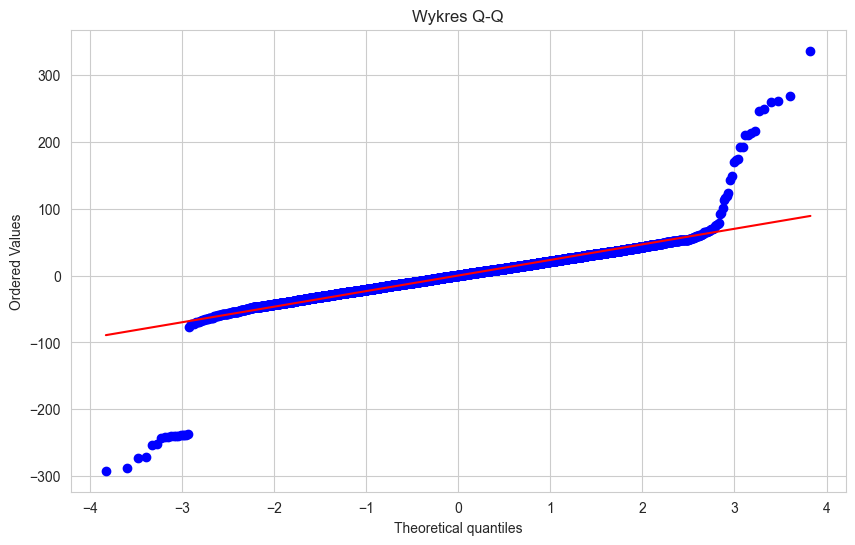

== Testy na normalność ==
Dane zostały poddane losowemu próbkowaniu (5000 próbek).
Shapiro-Wilk test: stat=0.8855788691690849, p-value=1.6690285853010705e-51
D'Agostino test: stat=3294.48735481223, p-value=0.0
Anderson-Darling test: stat=78.3032413342844
Na poziomie istotności 15.0%: dane nie wyglądają na normalne (stat >= 0.576)
Na poziomie istotności 10.0%: dane nie wyglądają na normalne (stat >= 0.656)
Na poziomie istotności 5.0%: dane nie wyglądają na normalne (stat >= 0.787)
Na poziomie istotności 2.5%: dane nie wyglądają na normalne (stat >= 0.918)
Na poziomie istotności 1.0%: dane nie wyglądają na normalne (stat >= 1.092)


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, normaltest, anderson

# Assuming 'data' is your input dictionary
df = pd.DataFrame(data)

# Histogram with Gaussian density curve
plt.figure(figsize=(10, 6))
plt.hist(residual, bins=15, density=True, alpha=0.6, color='g')
plt.title('Histogram z wykresem gęstości')
plt.xlabel('Egg Sales')
plt.ylabel('Gęstość')

# Fit Gaussian curve
mu, std = residual.mean(), residual.std()
x = np.linspace(mu - 3*std, mu + 3*std, 100)
plt.plot(x, stats.norm.pdf(x, mu, std), 'r', linewidth=2)
plt.show()

# Q-Q Plot
plt.figure(figsize=(10, 6))
stats.probplot(residual, dist="norm", plot=plt)
plt.title('Wykres Q-Q')
plt.show()

# Normality Tests
print("== Testy na normalność ==")

# 1. Shapiro-Wilk Test (subsample if needed)
if len(df) > 5000:
    subsample = residual.sample(5000, random_state=42)  # Take a random subset
    print("Dane zostały poddane losowemu próbkowaniu (5000 próbek).")
    shapiro_test = shapiro(subsample)
else:
    shapiro_test = shapiro(residual)
print(f"Shapiro-Wilk test: stat={shapiro_test[0]}, p-value={shapiro_test[1]}")

# 2. D'Agostino and Pearson's K² Test
dagostino_test = normaltest(residual)
print(f"D'Agostino test: stat={dagostino_test[0]}, p-value={dagostino_test[1]}")

# 3. Anderson-Darling Test
anderson_test = anderson(residual, dist='norm')
print(f"Anderson-Darling test: stat={anderson_test.statistic}")
for i in range(len(anderson_test.critical_values)):
    sl, cv = anderson_test.significance_level[i], anderson_test.critical_values[i]
    if anderson_test.statistic < cv:
        print(f"Na poziomie istotności {sl}%: dane wyglądają na normalne (stat < {cv})")
    else:
        print(f"Na poziomie istotności {sl}%: dane nie wyglądają na normalne (stat >= {cv})")


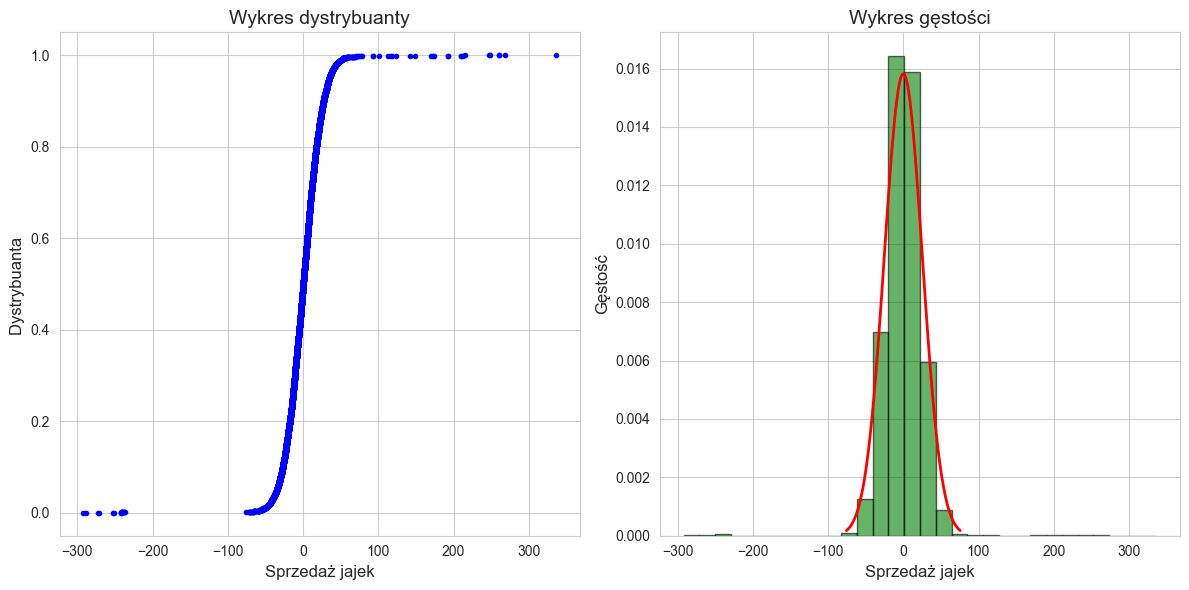

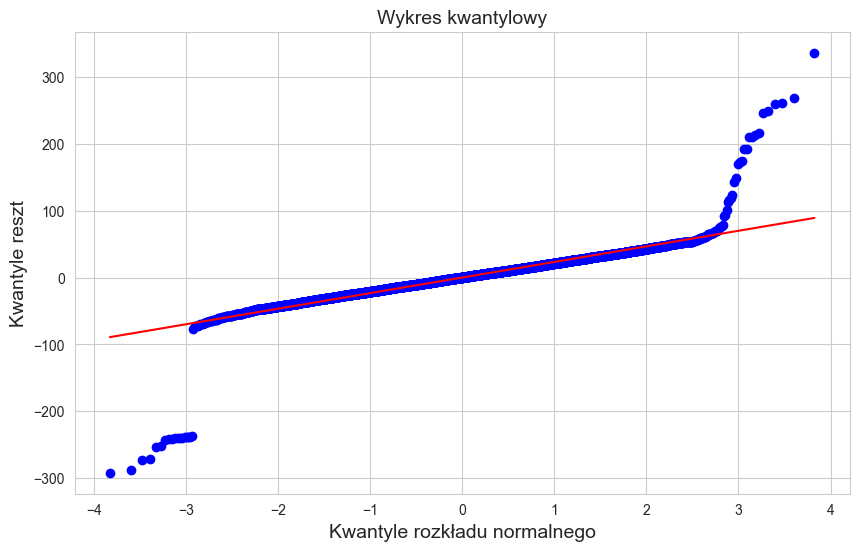

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats



# Wykres dystrybuanty
plt.figure(figsize=(12, 6))

# Wykres dystrybuanty (CDF)
plt.subplot(1, 2, 1)
# Sortujemy dane
sorted_residual = np.sort(residual)
# Obliczamy CDF
cdf = np.arange(1, len(sorted_residual) + 1) / len(sorted_residual)
plt.plot(sorted_residual, cdf, marker='.', linestyle='none', color='b')
plt.title('Wykres dystrybuanty', fontsize=14)
plt.xlabel('Sprzedaż jajek', fontsize=12)
plt.ylabel('Dystrybuanta ', fontsize=12)

# Histogram z wykresem gęstości
plt.subplot(1, 2, 2)
plt.hist(residual, bins=30, density=True, alpha=0.6, color='g', edgecolor='black')
mu, std = residual.mean(), residual.std()
x = np.linspace(mu - 3*std, mu + 3*std, 100)
plt.plot(x, stats.norm.pdf(x, mu, std), 'r', linewidth=2)
plt.title('Wykres gęstości', fontsize=14)
plt.xlabel('Sprzedaż jajek', fontsize=12)
plt.ylabel('Gęstość', fontsize=12)

plt.tight_layout()
plt.show()

# Wykres Q-Q (Quantile-Quantile plot)
plt.figure(figsize=(10, 6))
stats.probplot(residual, dist="norm", plot=plt)
plt.title('Wykres kwantylowy', fontsize=14)
plt.xlabel('Kwantyle rozkładu normalnego', fontsize=14)
plt.ylabel('Kwantyle reszt', fontsize=14)
plt.grid(True)
plt.show()
